## Instruction
In this notebook, We use data which I donwload from Tushare to make up some alpha factors and risk factors.
1. Load data which time range bettwen 2017.4 - 2023.3. download from privious step `DownLoad_from_Tushare.ipynb` 
2. Make up some factors based on some paper, tech indicators and fundamentls

## Load Data
load data which already download from Tushare

In [3]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

import warnings
warnings.filterwarnings('ignore')

In [6]:
universe_raw = pd.read_csv('all_20170405_20230327.csv')
#fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
#universe_raw = pd.read_csv('tmp.csv').iloc[:,1:]

In [ ]:
# load recent data
universe_recent = pd.read_csv('raw_20230103_20230327.csv').iloc[:,1:]
universe_recent = universe_recent.loc[universe_recent.ts_code.isin(fundamental_df.ts_code)]

In [ ]:
print(len(universe_raw.ts_code.unique()), len(universe_recent.ts_code.unique()))
print(len(universe_raw.columns.unique()), len(universe_recent.columns.unique()))

In [3]:
universe = universe_raw.copy(deep=True)
# reset pe is null to 1.e3
universe['pe'] = np.where(universe['pe'].isnull(), 1.*1e3, universe['pe'])
# fill pb null with a large value
universe['pb'] = np.where(universe['pb'].isnull(), 1.*1e2, universe['pb'])
# fill null to 0
universe['dt_eps'] = np.where(universe['dt_eps'].isnull(), 0., universe['dt_eps'])
universe['dt_eps_yoy'] = np.where(universe['dt_eps_yoy'].isnull(), 0., universe['dt_eps_yoy'])
universe['dt_eps_yoy'] = np.where(universe['dt_eps_yoy']>300, 300., np.where(universe['dt_eps_yoy']<-300, -300, universe['dt_eps_yoy']))
universe['p_change_max'] = np.where(universe['p_change_max'].isnull(), 0., universe['p_change_max'])
universe['p_change_max'] = np.where(universe['p_change_max']>300, 300., np.where(universe['p_change_max']<-300, -300, universe['p_change_max']))
# add volume
universe['volume'] = universe['amount']/universe['close']
universe = universe.drop_duplicates(['trade_date','ts_code'])

## Data Explain
  Some data columns about fundamental indicators below
  - 'cfps','revenue_ps', 'quick_ratio',  每股现金流，每股营业收入，速冻比率
  - 'dt_eps','basic_eps_yoy','dt_eps_yoy',  每股收益
  - 'bps','bps_yoy',  每股净资产
  - 'extra_item','profit_dedt', 扣非，扣非净利润
  - 'roe_dt','q_dt_roe','roe_yoy',  净资产收益
  - 'capital_rese_ps','surplus_rese_ps',  每股资本公积，每股公积盈余 
  - 'gross_margin','interestdebt','ca_to_assets', 毛利，带息债务, 流动资产/总资产
  - 'ebt_yoy','roe_yoy','or_yoy','equity_yoy' 总利润增长，净资产收益增长，营业收入增长，净资产增长
  
  If there are some columns named alpha begin, the data had processed completed. Each column named alpha_ is alpha factors

## Ticker Pool
After create factors we filte data by each day more in detail. 

In real trade with this model factor use, download data by each day, if you want to add new tickers into portfolio, ensure the ticker exist over 3 month. If add not successed after this process step, some conditions not satisfied our portfolio regular. 

In [4]:
# remove tickers by each day not exist history
def remove_tickers(df, exist_ticker_list):
    diff_df = df.loc[df.ts_code.isin(exist_ticker_list)==False]
    if diff_df.empty == False:
        # remove tickers not exist over 3month from day
        diff1 = (pd.to_datetime(diff_df['trade_date'],format='%Y%m%d')\
                -pd.to_datetime(diff_df['list_date'],format='%Y%m%d')).apply(lambda x: x.days) < 90
        # remove tickers pe > 60
        diff2 = diff_df.pe > 60
        # remove tickers pb > 10
        diff3 = diff_df.pb > 8
        # remove fundamental bad
        diff4 = diff_df['type_value']<-1
        # dt_eps <0 means profit is below 0.3 , remove it.
        diff5 = diff_df['dt_eps']<0.3
        # total_mv>50 billion
        diff6 = diff_df['total_mv']>5000000
        # get remove df
        diff_df = diff_df.loc[diff1| diff2| diff3| diff4| diff5| diff6]
        # get rest data
        df = df.loc[df.ts_code.isin(diff_df.ts_code)==False]
    return df

calendar = universe.trade_date.unique()
df_all = pd.DataFrame()
for dt in tqdm(calendar, desc='filter tikers'):
    tmp = universe.loc[universe['trade_date']==dt]
    if df_all.empty:
        tmp = remove_tickers(tmp, [])
    else:
        tmp = remove_tickers(tmp, df_all.ts_code.unique())
    df_all = df_all.append(tmp, ignore_index=True)
universe = df_all
universe['date'] = pd.to_datetime(universe['trade_date'], format='%Y%m%d')
universe = universe.set_index(['date']).sort_values(by=['date'])
# update stock list
#fundamental_df = fundamental_df.loc[fundamental_df.ts_code.isin(universe.ts_code.unique())]
print(universe.shape, len(universe.ts_code.unique()))

filter tikers: 100%|████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 130.79it/s]

(9833, 57) 52


In [7]:
reset_field = ['ts_code', 'trade_date', 'turnover_rate', 'amount', 'pe', 'pb', 'total_share', 'total_mv', 'volume',
         'open', 'close', 'high', 'low', 'cci', 
         'name', 'industry', 'list_date', 'issue_price', 'issue_amount',
         'type', 'type_value', 'p_change_min','p_change_max', 
         'cfps', 'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy', 'dt_eps_yoy',
         'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt', 'q_dt_roe',
         'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps', 'gross_margin',
         'interestdebt', 'ca_to_assets', 'ebt_yoy', 'or_yoy', 'equity_yoy']
universe = universe[reset_field]
#universe.head()

### Overnight Return
This factor we had did in P4, 

We calculate factor here, and add sma indicators later.

$factor=(open_{today}-close_{yesterday})\div close_{yesterday}$

In [8]:
class CloseToOpen(pd.DataFrame):
    """
        Overnight Return Factor Constructor
    """
    def __init__(self,data):
        super(CloseToOpen, self).__init__(data)
        self.df = self

    def calculate(self):
        '''
        add open-close as a column named close_to_return
        :return: dataframe
        '''
        unique_ticker = self.df.ts_code.unique()
        tmp_df = pd.DataFrame()
        for ts_code in tqdm(unique_ticker, desc='close_to_open'):
            stock = self.df.loc[self.df.ts_code == ts_code][["ts_code", "trade_date", "open", "close"]]
            stock['alpha_close2open'] = (stock['open'].shift(-1).fillna(method='ffill') - stock['close'])/stock['close']
            tmp_df = tmp_df.append(stock, ignore_index=True)
        self.df = self.df.merge(tmp_df[["ts_code", "trade_date", "alpha_close2open"]], on=["ts_code", "trade_date"], how="inner")
        self.df['date'] = pd.to_datetime(self.df['trade_date'], format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return self.df
    

universe = CloseToOpen(universe).calculate()

close_to_open: 100%|██████████████████████████| 468/468 [00:16<00:00, 28.98it/s]


## Add Technology Indicators

In [9]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code','trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date']).drop_duplicates(['trade_date','ts_code'])
        return self.df
    

In [10]:
# add tech indicators
tech_indicator_list = [
                       'supertrend','close_5_sma','close_20_sma','turnover_rate_5_sma',
                       'log-ret','atr_5','cci_6', 'vwma_2','vwma_25',
                       'close_10_kama_2_30', 'close_10_kama_5_30','close_2_kama',
                       'alpha_close2open_5_sma', 'alpha_close2open_25_sma'
                      ] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)
# 'close_2_kama_20_mstd'

add tech indicators: 100%|████████████████████| 468/468 [05:23<00:00,  1.45it/s]


## Constructor Factors Based on Indicators

### Supertrend Factors
This factor based on supertrend and close 5 days sma

In [11]:
universe['alpha_supertrend'] = universe['close'] - universe['supertrend']

### CCI Factors
This factor based on cci and atr 5 days window

In [12]:
universe['alpha_cci'] = np.where(universe['cci_6']>200, (universe['cci_6']-200)/universe['turnover_rate_5_sma'], \
                      np.where(universe['cci_6']<-200, (universe['cci_6']+200)/universe['turnover_rate_5_sma'], universe['turnover_rate']))

### KAMA Factors

In [14]:
universe['close_2_kama'] = \
    np.where(universe['close_2_kama'].isnull()==True,universe['close_5_sma'], universe['close_2_kama'])

In [15]:
# add KAMA alpha factor
def KAMA_filter(df):    
    unique_stocks = df.ts_code.unique()
    all_df = pd.DataFrame()
    for ts_code in tqdm(unique_stocks, desc='kama filter'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['kama_filter'] = tmp['close_2_kama'].rolling(window=20).std().fillna(method='bfill') 
        tmp['kama_prior'] = tmp['close_2_kama'].shift(5).fillna(method='bfill')
        #tmp['alpha_kama'] = (tmp['close_2_kama'] - tmp['kama_prior'] - tmp['kama_filter'])+ (tmp['close_10_kama_2_30'] - tmp['close_10_kama_5_30'])
        tmp['alpha_kama'] = tmp['close_2_kama'] - tmp['kama_prior'] - tmp['kama_filter']
        all_df = all_df.append(tmp[['ts_code','trade_date','alpha_kama']], ignore_index=True)
    df = df.merge(all_df, on=['ts_code','trade_date'], how='left')
    df['date'] = pd.to_datetime(df['trade_date'],format='%Y%m%d')
    df = df.set_index(['date']).sort_values(by=['date'])
    return df

#temp = universe.loc[universe.ts_code=='603538.SH']
#temp = KAMA_filter(temp)
universe = KAMA_filter(universe)

kama filter: 100%|████████████████████████████| 468/468 [00:18<00:00, 25.66it/s]


## Constructor Factors Based on Paper
### Overnight Return

In [16]:
# we had did process overnight return factors before
universe['alpha_close2open_25_sma'] = -universe['alpha_close2open_25_sma']

### Winner And Loser
This factor we also did in P4. It express a ticker how to reach a return in a spicific period time 

We use a time window as T, and regression d and v $return = T*d + T^2*v$  => $factor=d*v$ 

In [14]:
from statsmodels.formula.api import ols

class WinnerAndLoser(pd.DataFrame):
    """
        Winner and Loser Factor Constructor
    """
    def __init__(self,data, win_length=20):
        super(WinnerAndLoser, self).__init__(data)
        self.df = self
        self.win_lenth = win_length

    def _regression(self, data):
        df = pd.DataFrame(data, columns=['log-ret'])
        df['acc_ret'] = df['log-ret'].cumsum()
        df['t_dir'] = np.arange(self.win_lenth)+1
        df['t_velocity'] = df['t_dir'] ** 2
        regression = ols(formula='acc_ret ~ 0 + t_dir + t_velocity', data=df)
        model = regression.fit()
        data['alpha_winlos'] = model.params.t_dir * abs(model.params.t_velocity)
        return  data['alpha_winlos']


    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        tickers = self.df.ts_code.unique()
        factor_df = pd.DataFrame()
        for ticker in tqdm(tickers, desc='winner and loser'):
            tmp_df = self.df.loc[self.df.ts_code == ticker][['trade_date', 'ts_code', 'log-ret']]
            tmp_df['alpha_winlos'] = tmp_df['log-ret'].rolling(self.win_lenth).apply(self._regression)
            tmp_df['alpha_winlos'].fillna(method='bfill',inplace=True)
            factor_df = factor_df.append(tmp_df, ignore_index=True)
        self.df = self.df.merge(factor_df[["ts_code", "trade_date", "alpha_winlos"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return  self.df
    
    
#test = universe.loc[universe.ts_code=='603538.SH']
#test = universe.loc[universe.ts_code=='002038.SZ']
#test = WinnerAndLoser(test).calculate()
universe = WinnerAndLoser(universe).calculate()

winner and loser: 100%|████████████████████████████████████████████████████████████████| 52/52 [01:07<00:00,  1.29s/it]


### Skew And Momentum
This factor we also did in P4. It express minority and majority sentiment of investor how to impact on market.

We calculate skew and median of log-return distribution in a period time, the skew view as marjority sentiment and median can view as minority sentiment.

$factor = abs(skew) * median 

In [17]:
class SkewandMomentum(pd.DataFrame):
    """
        Expected Skewness and Momentum Factor Constructor
    """
    def __init__(self,data, win_length=20):
        super(SkewandMomentum, self).__init__(data)
        self.df = self
        self.win_length = win_length

    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        def calculate_factor(data):
            return data.skew() * data.median()
        
        tmp_df = pd.DataFrame()
        for stock_tuple in tqdm(self.groupby('ts_code'), desc='skew and momentum'):
            stock = stock_tuple[1]
            stock['alpha_skew2sentiment'] = stock['log-ret'].rolling(self.win_length).apply(calculate_factor)
            stock['alpha_skew2sentiment'] = stock['alpha_skew2sentiment'].fillna(method='bfill')
            tmp_df = tmp_df.append(stock,ignore_index=True)
        self.df = self.df.merge(tmp_df[["ts_code", "trade_date", "alpha_skew2sentiment"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return self.df


#temp = universe.loc[universe.ts_code=='603538.SH']
#test = universe.loc[universe.ts_code=='002038.SZ']
#temp = SkewandMomentum(temp).calculate()
universe = SkewandMomentum(universe).calculate()

skew and momentum: 100%|██████████████████████| 468/468 [03:19<00:00,  2.35it/s]


## Fundamental Factor
This factor based on ticker fundamentals, it usually take a long period time to archive return. So called take a long line to catch a big fish! 


In [80]:
from scipy.stats import zscore

def alpha_fundamental(df):
    all_df = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='fundamental factor'):
        tmp = df.loc[df.ts_code==ts_code]
        tmp['alpha_fundamental'] = (1+(tmp['p_change_max']+tmp['p_change_min'])/200) * tmp['dt_eps'] \
                                / (tmp['close_5_sma'] * tmp['turnover_rate_5_sma'])
        all_df = all_df.append(tmp, ignore_index=True)
        
    df = df.merge(all_df[['ts_code','trade_date','alpha_fundamental']], on=['ts_code','trade_date'], how='left')
    df['date'] = pd.to_datetime(df['trade_date'],format='%Y%m%d')
    df = df.set_index(['date']).sort_values(by=['date'])
    return df
   

#temp = universe.loc[universe.ts_code=='603538.SH']
#temp = alpha_fundamental(temp)
#universe = universe.drop(columns=['alpha_fundamental'])
universe = alpha_fundamental(universe)

fundamental factor: 100%|█████████████████████| 468/468 [01:06<00:00,  7.07it/s]


## Zscore Alpha Factors
As computer use factor to compare each oter before all factors had same scales. So we rescale each factors by zscore in each day and each industry. 

Here we pick some features as mechine learning step in the next step.

In [81]:
from scipy.stats import zscore

# add alpha_winlos columns if run this factor
zscore_features = [
       'turnover_rate', 'amount', 'total_mv', 'atr_5', 'pe', 'pb', 'revenue_ps', 'p_change_max', 
       'dt_eps_yoy', 'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'equity_yoy',
       'alpha_cci', 'alpha_supertrend', 'alpha_kama', 'alpha_close2open_5_sma',
       'alpha_close2open_25_sma', 'alpha_skew2sentiment', 'alpha_fundamental', 
       # 'alpha_winlos'
        ]

def zscore_by_sector(df):
    df_all = pd.DataFrame()
    for industry in df.industry.unique():
        tmp = df.loc[df.industry == industry]
        tmp[zscore_features] = tmp.groupby('trade_date')[zscore_features].apply(zscore)
        df_all = df_all.append(tmp)

    return df_all.fillna(0)  

universe_raw = zscore_by_sector(universe)

In [82]:
universe_raw[zscore_features+['ts_code', 'trade_date', 'industry']].sort_values(by=['date', 'alpha_fundamental']).tail(5)

,turnover_rate,amount,total_mv,atr_5,pe,pb,revenue_ps,p_change_max,dt_eps_yoy,bps_yoy,...,alpha_cci,alpha_supertrend,alpha_kama,alpha_close2open_5_sma,alpha_close2open_25_sma,alpha_skew2sentiment,alpha_fundamental,ts_code,trade_date,industry
date,,,,,,,,,,,,,,,,,,,,,
2023-03-27,-0.759722,-0.244192,0.591304,-1.031209,-1.593460,-1.855827,2.389929,0.0,-0.772821,-0.343521,...,-0.759722,0.198188,0.365138,0.465766,-0.379550,-0.083857,2.728818,600739.SH,20230327,生物制药
2023-03-27,-1.221933,-1.129887,-0.648862,-0.691311,-1.134614,-0.971510,-0.632882,0.0,-0.672466,-0.574693,...,-1.221933,-0.570289,0.115954,1.899526,-1.957194,-0.549331,2.786678,603258.SH,20230327,互联网
2023-03-27,-0.428222,0.052567,1.207167,-0.599472,-1.027326,-0.803746,0.586117,0.0,-1.172008,0.388787,...,-0.428222,0.537905,0.480281,0.491509,-0.480587,-0.274058,2.924296,600998.SH,20230327,医药商业
2023-03-27,-0.689212,0.482639,3.033026,-0.331549,-1.387422,-1.498836,4.441157,0.0,-0.127820,0.595265,...,-0.689212,-0.406854,0.095806,-0.108189,0.075106,0.468026,3.032956,600332.SH,20230327,中成药
2023-03-27,-1.002539,-0.511516,-0.418318,-0.767870,-2.001351,-1.950750,-0.932318,0.0,-0.405056,-0.911550,...,-1.002539,-0.747244,-0.026396,2.328397,-2.244202,-0.386329,4.069983,603508.SH,20230327,软件服务


## Save All Data and factors to csv

In [ ]:
# add recent data
print(len(universe_raw.columns.unique()), len(universe.columns.unique()))
print(universe_raw.index[-1], universe.index[-1])
# universe_raw = universe_raw.drop(columns=['rsi_6']).set_index(['date'])
# for col in universe_raw.columns:
#     if col not in universe.columns:
#         print(col)
universe_raw = universe_raw.append(universe.loc[universe['trade_date']>20230317])
fundamental_df = fundamental_df.loc[fundamental_df.ts_code.isin(universe_raw.ts_code.unique())]
print(len(universe_raw.ts_code.unique()), len(fundamental_df.ts_code.unique()))
universe_raw.head()

In [84]:
## save all data
# fundamental_df.to_csv('fundamental_20170405_20230327.csv')
# universe_raw[features].to_csv('factors_20170405_20230327.csv')
universe_raw.to_csv('all_20170405_20230327.csv')

### Load complete data from csv

In [ ]:
# load data from file
universe_raw = pd.read_csv('all_20170405_20230327.csv')
universe_raw['date'] = pd.to_datetime(universe_raw['date'],format='%Y-%m-%d')
universe_raw.set_index(['date'],inplace=True)

### Test and View

In [70]:
# make factor and zscore
test = universe_raw.copy(deep=True)
test['factor_test'] = (1+(test['p_change_max']+test['p_change_min'])/200) * test['dt_eps'] \
                    / (test['close_5_sma'] * test['turnover_rate_5_sma'])
test = zscore_by_sector(test)

In [76]:
# check tikcer data
test.loc[test.ts_code=='603538.SH'].tail()[['p_change_max','p_change_min','dt_eps','close','turnover_rate_5_sma']]

In [83]:
# got top 5 factor values of tiker and graph history line
check_df = test[zscore_features+['close', 'ts_code', 'trade_date', 'industry']]\
    .sort_values(by=['date', 'factor_test']).tail(5)
ts_codes = check_df.ts_code.unique()
for code in ts_codes:
    tmp = test.loc[(test.ts_code==code)]
    # indicator test
    tmp = tmp.loc[(tmp['trade_date']>20220301) & (tmp['trade_date']<20230401)]
    tmp[['close','alpha_cci']] = tmp[['close','alpha_cci']].apply(zscore).fillna(method='bfill')
    tmp[['close', 'factor_test']].plot(grid=True, title=code)
check_df

<AxesSubplot:xlabel='date'>

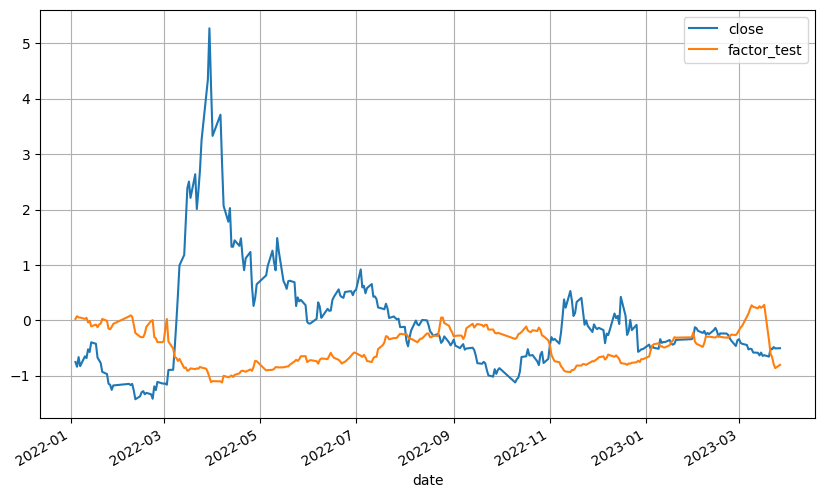

In [75]:
# graph factor of one history line 
from scipy.stats import zscore
tmp = test.loc[universe_raw.ts_code== '603538.SH']
tmp = tmp.loc[(tmp['trade_date']>20220101) & (tmp['trade_date']<20230401) ]
tmp[['close','cci_6']] = tmp[['close', 'cci_6']].apply(zscore).fillna(method='bfill')
#tmp['close'] = tmp['close'] -12
tmp[['close', 'factor_test']].plot(grid=True)
#tmp[['vwma_5', 'turnover_rate']].plot(grid=True)